In [9]:
import os
from glob import glob

dataset_path = "../data"

splits = {
    "train": "augmented",
    "valid": "raw/valid",
    "test": "raw/test"
}
extensions = ("*.jpg", "*.jpeg", "*.png")

for split_name, split_path in splits.items():
    img_dir = os.path.join(dataset_path, split_path, "images")
    label_dir = os.path.join(dataset_path, split_path, "labels")

    images = []
    for ext in extensions:
        images.extend(glob(os.path.join(img_dir, ext)))
    labels = glob(os.path.join(label_dir, "*.txt"))

    print(f"{split_name.upper()}: {len(images)} images, {len(labels)} labels")


TRAIN: 11139 images, 11139 labels
VALID: 1873 images, 1873 labels
TEST: 941 images, 941 labels


Class names: ['anger', 'content', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Number of classes: 8
Found 11139 label files
Processing ALL label files...


Processing labels: 100%|██████████| 11139/11139 [00:01<00:00, 10493.74it/s]


Total bounding boxes processed: 11288


<Figure size 1600x1000 with 0 Axes>

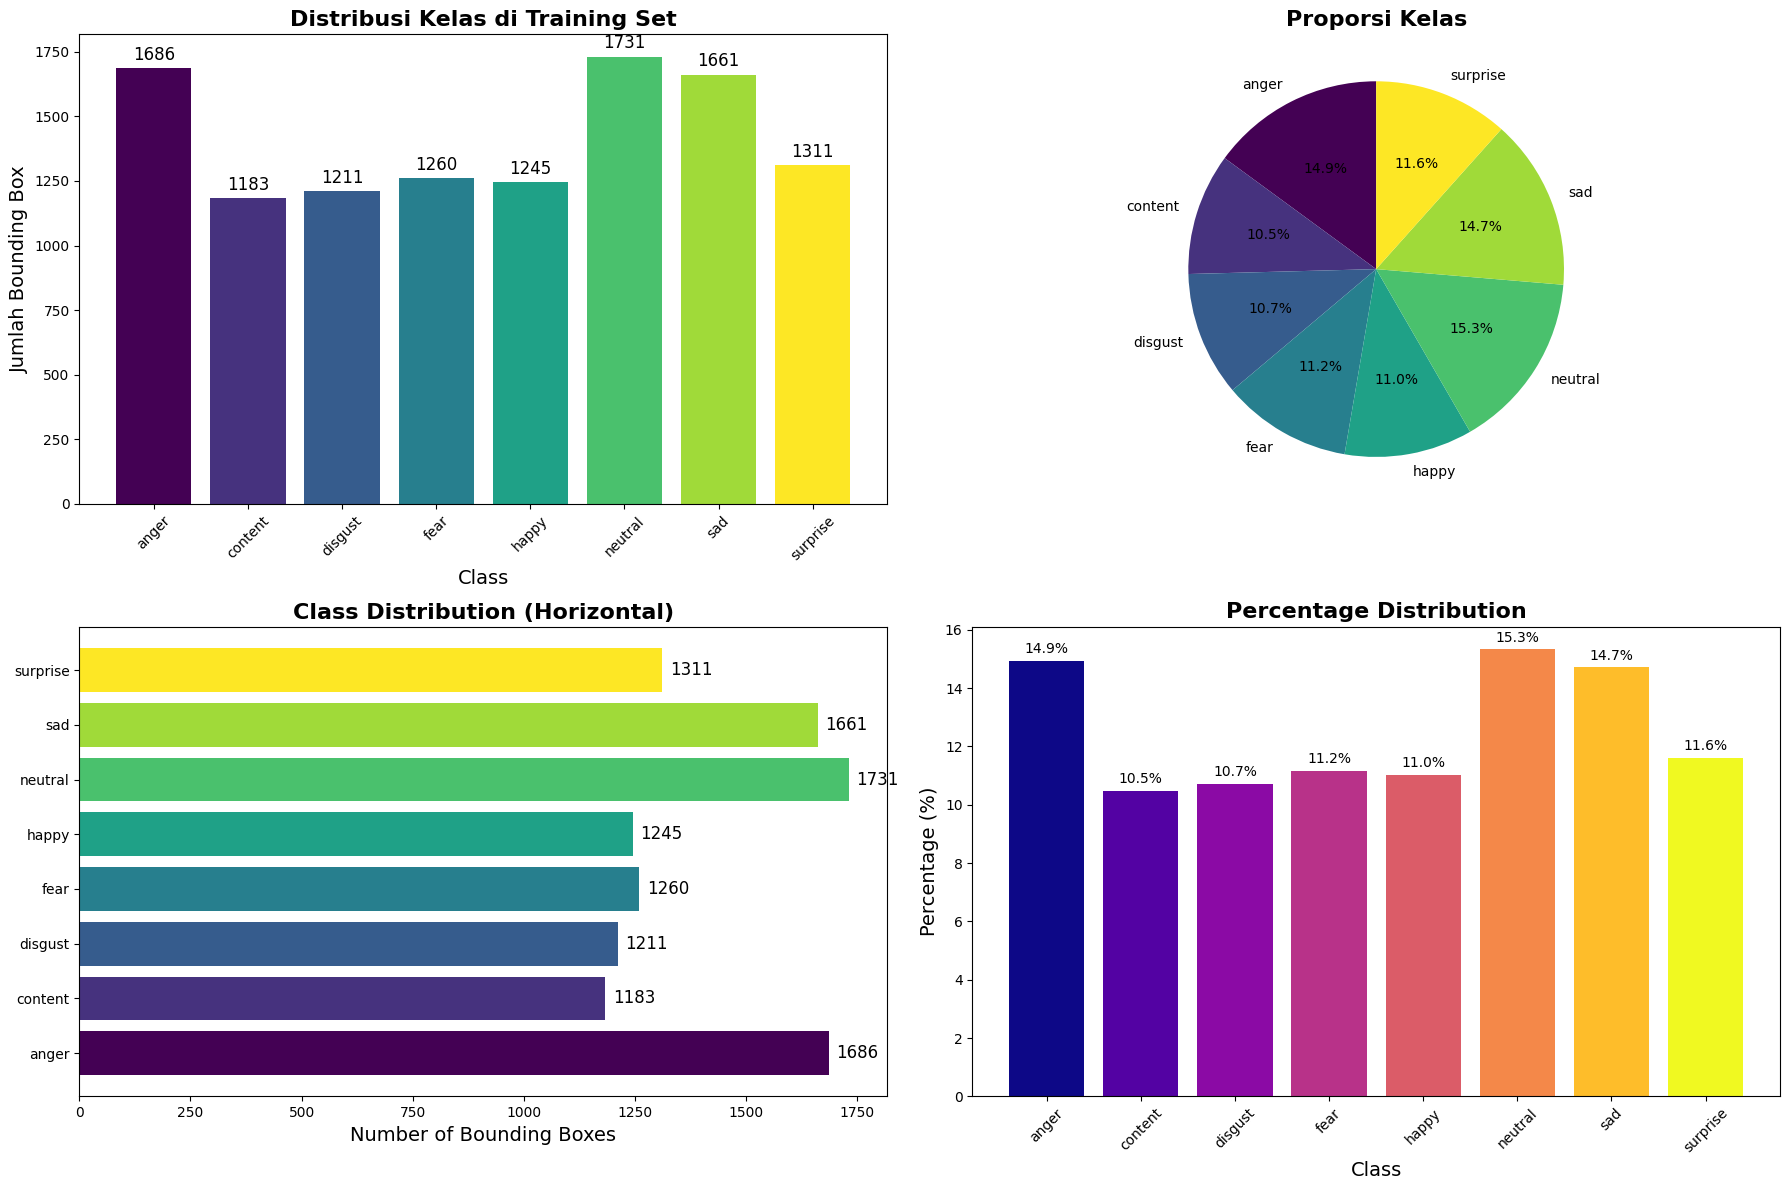


COMPLETE DATASET STATISTICS
Class        Count    Percentage   Samples/Class
------------------------------------------------------------
anger        1686     14.94        1686
content      1183     10.48        1183
disgust      1211     10.73        1211
fear         1260     11.16        1260
happy        1245     11.03        1245
neutral      1731     15.33        1731
sad          1661     14.71        1661
surprise     1311     11.61        1311

Total bounding boxes: 11288
Total label files processed: 11139
Average boxes per image: 1.01


In [10]:
import os
import glob
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from tqdm import tqdm
import numpy as np

# Set matplotlib to inline mode
# %matplotlib inline  # Uncomment if in Jupyter

# ================
# 1. Load data.yaml
# ================
data_yaml = "../data/augmented/data.yaml"
with open(data_yaml, "r") as f:
    data_cfg = yaml.safe_load(f)

class_names = data_cfg["names"]
num_classes = len(class_names)
print("Class names:", class_names)
print(f"Number of classes: {num_classes}")

# Note the updated class names: ['anger', 'content', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# =================
# 2. Count class distribution - PROCESS ALL FILES
# =================
train_labels = glob.glob("../data/augmented/labels/*.txt")
print(f"Found {len(train_labels)} label files")

class_counts = {i: 0 for i in range(num_classes)}
total_boxes = 0

# Process ALL label files (removed the [:1000] limit)
print("Processing ALL label files...")
for label_file in tqdm(train_labels, desc="Processing labels"):
    try:
        with open(label_file, "r") as f:
            lines = f.read().strip().split('\n')
            for line in lines:
                if line.strip():  # Skip empty lines
                    parts = line.strip().split()
                    if len(parts) >= 5:  # Ensure we have all required parts (class + 4 bbox coords)
                        cls_id = int(parts[0])
                        if 0 <= cls_id < num_classes:  # Validate class ID
                            class_counts[cls_id] += 1
                            total_boxes += 1
                        else:
                            print(f"Warning: Invalid class ID {cls_id} in {label_file}")
    except Exception as e:
        print(f"Error processing {label_file}: {e}")
        continue

print(f"Total bounding boxes processed: {total_boxes}")

# =================
# 3. Visualize distribution
# =================
plt.figure(figsize=(16, 10))

# Create subplots for better layout
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# 1. Bar plot
class_labels = [class_names[k] for k in range(num_classes)]
counts = [class_counts[k] for k in range(num_classes)]

bars = ax1.bar(class_labels, counts, color=plt.cm.viridis(np.linspace(0, 1, num_classes)))
ax1.set_title("Distribusi Kelas di Training Set", fontsize=16, fontweight='bold')
ax1.set_xlabel("Class", fontsize=14)
ax1.set_ylabel("Jumlah Bounding Box", fontsize=14)
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars
for i, (bar, count) in enumerate(zip(bars, counts)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + max(counts)*0.01, 
             f'{count}', ha='center', va='bottom', fontsize=12)

# 2. Pie chart
non_zero_counts = [(name, count) for name, count in zip(class_labels, counts) if count > 0]
if non_zero_counts:
    pie_labels, pie_counts = zip(*non_zero_counts)
    colors = plt.cm.viridis(np.linspace(0, 1, len(pie_labels)))
    wedges, texts, autotexts = ax2.pie(pie_counts, labels=pie_labels, autopct='%1.1f%%', 
                                       colors=colors, startangle=90)
    ax2.set_title("Proporsi Kelas", fontsize=16, fontweight='bold')

# 3. Horizontal bar chart (easier to read class names)
y_pos = np.arange(len(class_labels))
bars_h = ax3.barh(y_pos, counts, color=plt.cm.viridis(np.linspace(0, 1, num_classes)))
ax3.set_yticks(y_pos)
ax3.set_yticklabels(class_labels)
ax3.set_xlabel('Number of Bounding Boxes', fontsize=14)
ax3.set_title('Class Distribution (Horizontal)', fontsize=16, fontweight='bold')

# Add value labels on horizontal bars
for i, (bar, count) in enumerate(zip(bars_h, counts)):
    width = bar.get_width()
    ax3.text(width + max(counts)*0.01, bar.get_y() + bar.get_height()/2., 
             f'{count}', ha='left', va='center', fontsize=12)

# 4. Class imbalance visualization
if total_boxes > 0:
    percentages = [(count / total_boxes * 100) for count in counts]
    bars_pct = ax4.bar(class_labels, percentages, color=plt.cm.plasma(np.linspace(0, 1, num_classes)))
    ax4.set_title("Percentage Distribution", fontsize=16, fontweight='bold')
    ax4.set_xlabel("Class", fontsize=14)
    ax4.set_ylabel("Percentage (%)", fontsize=14)
    ax4.tick_params(axis='x', rotation=45)
    
    # Add percentage labels
    for i, (bar, pct) in enumerate(zip(bars_pct, percentages)):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + max(percentages)*0.01, 
                 f'{pct:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# =================
# 4. Print detailed statistics
# =================
print("\n" + "="*60)
print("COMPLETE DATASET STATISTICS")
print("="*60)
print(f"{'Class':<12} {'Count':<8} {'Percentage':<12} {'Samples/Class'}")
print("-" * 60)

for i, class_name in enumerate(class_names):
    count = class_counts[i]
    percentage = (count / total_boxes * 100) if total_boxes > 0 else 0
    samples_per_class = count
    print(f"{class_name:<12} {count:<8} {percentage:<12.2f} {samples_per_class}")

print(f"\nTotal bounding boxes: {total_boxes}")
print(f"Total label files processed: {len(train_labels)}")
print(f"Average boxes per image: {total_boxes/len(train_labels):.2f}")


        
        

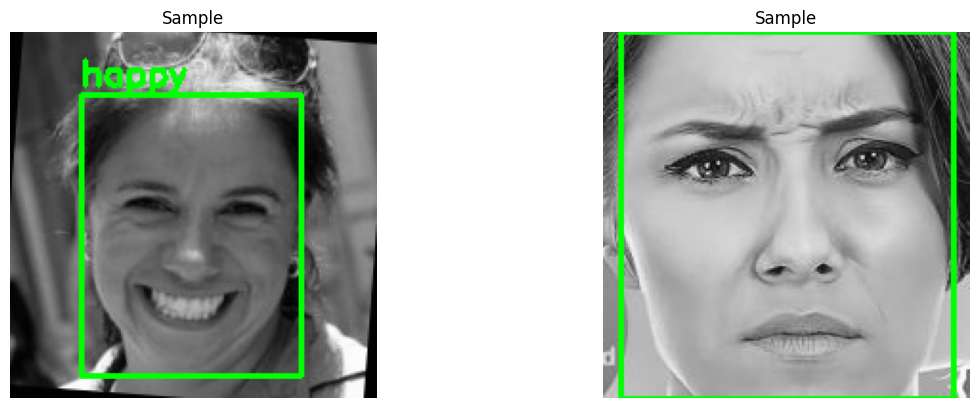

In [17]:
%matplotlib inline

# =================
# 3. Visualisasi contoh gambar
# =================
def plot_random_images(img_dir, label_dir, n=4):
    img_files = glob.glob(os.path.join(img_dir, "*.jpg")) + glob.glob(os.path.join(img_dir, "*.png"))
    
    if len(img_files) == 0:
        print("⚠️ Tidak ada gambar di folder:", img_dir)
        return
    
    # Biar tidak error kalau n > jumlah gambar
    n = min(n, len(img_files))
    sample_imgs = random.sample(img_files, n)

    plt.figure(figsize=(12, 8))
    for i, img_path in enumerate(sample_imgs, 1):
        img = cv2.imread(img_path)
        h, w, _ = img.shape
        label_path = os.path.join(
            label_dir, 
            os.path.basename(img_path).replace(".jpg", ".txt").replace(".png", ".txt")
        )

        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f.readlines():
                    cls, x, y, bw, bh = map(float, line.strip().split())
                    cls = int(cls)
                    # convert xywh (normalized) -> pixel
                    x1 = int((x - bw/2) * w)
                    y1 = int((y - bh/2) * h)
                    x2 = int((x + bw/2) * w)
                    y2 = int((y + bh/2) * h)
                    color = (0, 255, 0)
                    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                    cv2.putText(img, class_names[cls], (x1, y1-5),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 2, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title("Sample")

    plt.tight_layout()
    plt.show()

# contoh 4 random gambar dari train set
plot_random_images(
    "../data/augmented/images", 
    "../data/augmented/labels", 
    n=2
)
